# MODIS Land Types Data Exploration

In [2]:
import earthaccess
from utils.location import get_location

lon, lat = get_location()

loc_range = 7

lat_min = lat - loc_range
lat_max = lat + loc_range
lon_min = lon - loc_range
lon_max = lon + loc_range

auth = earthaccess.login()
results = earthaccess.search_data(
    short_name="MCD12Q1",
    temporal=("2024-01-01", "2025-01-02"),
    bounding_box=(lon_min, lat_min, lon_max, lat_max)
)

In [3]:
print(len(results))
print(results[0].data_links()[0])

4
https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/MCD12Q1.061/MCD12Q1.A2024001.h19v03.061.2025205183907/MCD12Q1.A2024001.h19v03.061.2025205183907.hdf


In [4]:
files = earthaccess.download(results, '../data/raw')

QUEUEING TASKS | :   0%|          | 0/4 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/4 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/4 [00:00<?, ?it/s]

In [5]:
import rioxarray as rxr
import xarray as xr
from typing import cast

datasets = [ rxr.open_rasterio(f'../data/raw/{file.name}', masked=True, chunks={'x': 1024, 'y': 1024})
                for file in files]

datasets[0]

<xarray.Dataset> Size: 300MB
Dimensions:              (band: 1, x: 2400, y: 2400)
Coordinates:
  * band                 (band) int64 8B 1
  * x                    (x) float64 19kB 1.112e+06 1.113e+06 ... 2.224e+06
  * y                    (y) float64 19kB 6.671e+06 6.671e+06 ... 5.56e+06
    spatial_ref          int64 8B 0
Data variables: (12/13)
    LC_Type1             (band, y, x) float32 23MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    LC_Prop2             (band, y, x) float32 23MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    LC_Prop3             (band, y, x) float32 23MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    QC                   (band, y, x) float32 23MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    LW                   (band, y, x) float32 23MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    LC_Type2             (band, y, x) float32 23MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    ...                   ...
    LC_Type4             (band, y, x) float32 23MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    LC_Type5             (band, y, x) float32 23MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    LC_Prop1_Assessment  (band, y, x) float32 23MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    LC_Prop2_Assessment  (band, y, x) float32 23MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    LC_Prop3_Assessment  (band, y, x) float32 23MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    LC_Prop1             (band, y, x) float32 23MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
Attributes: (12/64)
    ALGORITHMPACKAGEACCEPTANCEDATE:     1998-01-01
    ALGORITHMPACKAGEMATURITYCODE:       LAUNCH
    ALGORITHMPACKAGENAME:               MOD12Q1
    ALGORITHMPACKAGEVERSION:            V2.0
    ASSOCIATEDINSTRUMENTSHORTNAME.1:    MODIS
    ASSOCIATEDINSTRUMENTSHORTNAME.2:    MODIS
    ...                                 ...
    SOUTHBOUNDINGCOORDINATE:            50.0
    SPSOPARAMETERS:                     2669
    TileID:                             51019003
    VERSIONID:                          61
    VERTICALTILENUMBER:                 3
    WESTBOUNDINGCOORDINATE:             15.557238

In [6]:
import numpy as np


if not all(isinstance(x, xr.Dataset) for x in datasets):
    raise SystemExit("Datasets are not in correct format")

ds_latlon = [ ds.rio.reproject("EPSG:4326", dtype="float32", nodata=np.nan, resolution=0.01,
                              transform=None, shape=None, 
                              resampling="nearest", 
                              chunks={'x': 512, 'y': 512}) for ds in datasets ]

ds = xr.concat(ds_latlon, dim="time", join='outer')

years = [int(f.name[9:13]) for f in files]
ds = ds.assign_coords(time=("time", years))


In [7]:
land_types_ds = ds.where(
        (ds["y"] >= lat_min)
        & (ds["y"] <= lat_max)
        & (ds["x"] >= lon_min)
        & (ds["x"] <= lon_max),
        drop=True,
    )

land_types_df = land_types_ds[["LC_Type1", "x", "y", "time"]].to_dataframe().reset_index()

land_types_df = land_types_df.rename(columns={"y": "lat", "x": "lon", "LC_Type1": "land_cover_type"})
land_types_df = land_types_df.dropna(subset=["land_cover_type"])
types = datasets[0]['LC_Type1'].attrs
keys = list(types.keys())
values = list(types.values())

land_types_df['land_cover_type_name'] = [keys[values.index(lc_type)] for lc_type in land_types_df['land_cover_type']]
land_types_df

time  band     lat        lon  land_cover_type  spatial_ref  \
1955455   2024     1  50.005  15.562238             12.0            0   
1955458   2024     1  50.005  15.572238             12.0            0   
1955461   2024     1  50.005  15.582238             12.0            0   
1955464   2024     1  50.005  15.592238             12.0            0   
1955467   2024     1  50.005  15.602238             12.0            0   
...        ...   ...     ...        ...              ...          ...   
15197450  2024     1  49.995  26.079073             12.0            0   
15197452  2024     1  49.995  26.089073             12.0            0   
15197454  2024     1  49.995  26.099073             12.0            0   
15197456  2024     1  49.995  26.109073             12.0            0   
15197458  2024     1  49.995  26.119073             12.0            0   

         land_cover_type_name  
1955455             Croplands  
1955458             Croplands  
1955461             Croplands  
1955464             Croplands  
1955467             Croplands  
...                       ...  
15197450            Croplands  
15197452            Croplands  
15197454            Croplands  
15197456            Croplands  
15197458            Croplands  

[1960810 rows x 7 columns]

In [8]:
COLORS = {
    "Unclassified": [0, 0, 0],                          #255
    "Evergreen Needleleaf Forests": [0, 100, 0],        #1
    "Evergreen Broadleaf Forests": [0, 150, 80],        #2
    "Deciduous Needleleaf Forests": [102, 153, 0],      #3
    "Deciduous Broadleaf Forests": [104, 171, 95],      #4
    "Mixed Forests": [34, 139, 34],                     #5
    "Closed Shrublands": [181, 101, 29],                #6
    "Open Shrublands": [210, 180, 140],                 #7
    "Woody Savannas": [189, 183, 107],                  #8
    "Savannas": [240, 230, 140],                        #9
    "Grasslands": [204, 255, 153],                      #10
    "Permanent Wetlands": [0, 102, 204],                #11
    "Croplands": [255, 255, 128],                       #12
    "Urban and Built-up Lands": [220, 20, 60],          #13
    "Cropland/Natural Vegetation Mosaics": [255, 204, 102], #14
    "Permanent Snow and Ice": [240, 248, 255],          #15
    "Barren": [160, 82, 45],                            #16
    "Water Bodies": [0, 0, 255],                        #17
}

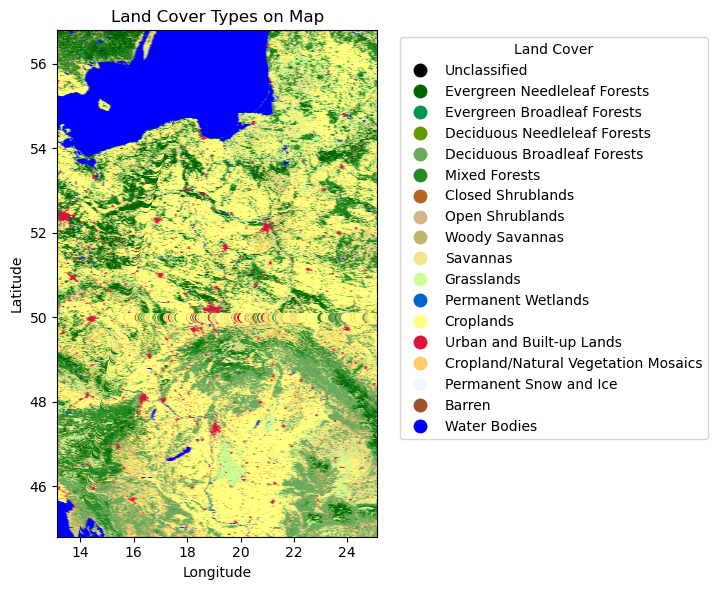

In [15]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl

gdf = gpd.GeoDataFrame(land_types_df, geometry=gpd.points_from_xy(land_types_df.lon, land_types_df.lat), crs='EPSG:4326')
norm_colors = list(map(lambda arr: list(map(lambda v: v/255, arr)), COLORS.values()))

cmap = mpl.colors.ListedColormap(norm_colors)

ax = gdf.plot(column='land_cover_type_name', cmap=cmap, markersize=30, legend=True, categorical=True, categories=COLORS, figsize=(6, 6), legend_kwds={'loc': 'upper left', 'bbox_to_anchor': (1.05, 1), "title":"Land Cover"})
ax.axis((gdf['lon'].min() + 1,
    gdf['lon'].max() - 1,
    gdf['lat'].min() + 1,
    gdf['lat'].max() - 1))


plt.title("Land Cover Types on Map")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.tight_layout()
plt.show()

In [17]:
gdf.to_parquet('../data/processed/land_cover_types.parquet')

In [ ]:
from lonboard import Map, ScatterplotLayer
from lonboard.basemap import CartoStyle
from lonboard.colormap import apply_categorical_cmap

land_types_cmap = apply_categorical_cmap(
    gdf['land_cover_type_name'],
    COLORS,
    alpha=5
)
layer = ScatterplotLayer.from_geopandas(gdf, get_fill_color=land_types_cmap, get_line_color=land_types_cmap, line_width_min_pixels=10, radius_min_pixels=5)
view_state = {
    "longitude": lon,
    "latitude": lat,
    "zoom": 5,
}
m = Map(layer, height=800, view_state=view_state, basemap_style=CartoStyle.Voyager)
display(m)

Map(basemap=MaplibreBasemap(style=<CartoStyle.Voyager: 'https://basemaps.cartocdn.com/gl/voyager-gl-style/styl…

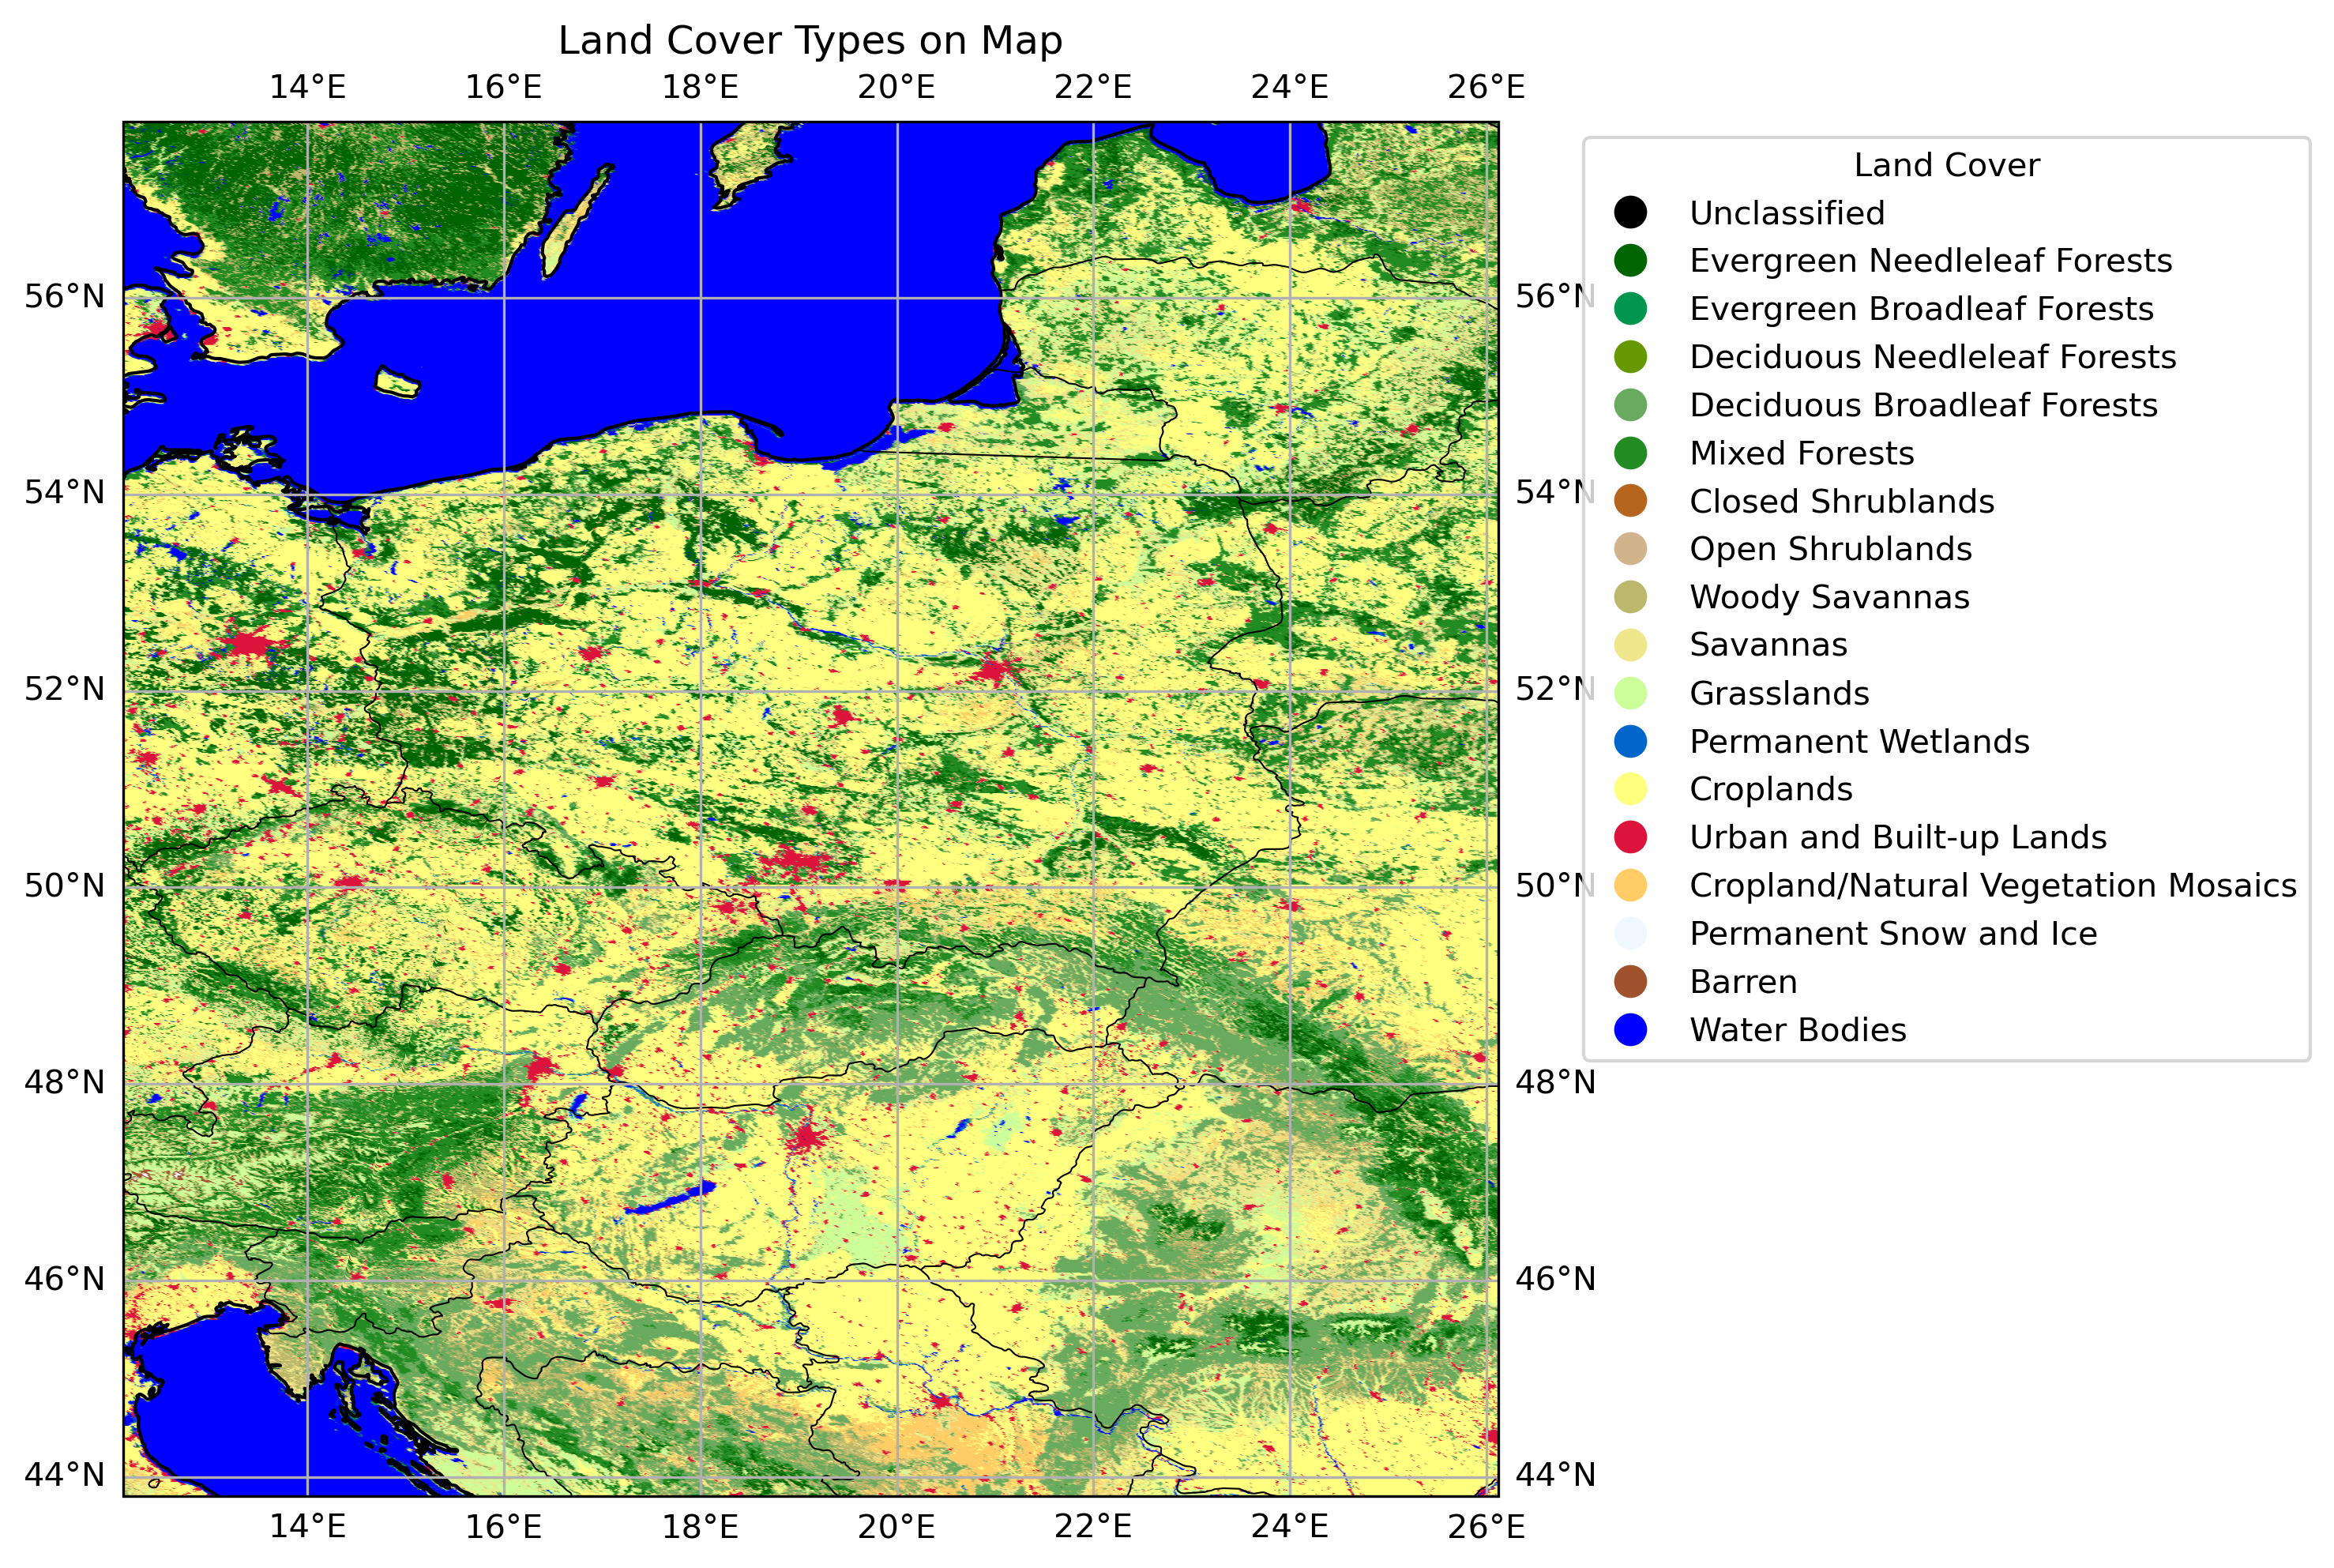

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.feature as cfeature

fig = plt.figure(figsize=(10, 10), dpi=300)
crs = ccrs.PlateCarree()

ax = plt.axes(projection=crs)

gdf = gpd.GeoDataFrame(
    land_types_df,
    geometry=gpd.points_from_xy(land_types_df.lon, land_types_df.lat),
    crs="EPSG:4326",
)
gdf = gdf.to_crs(crs.proj4_init)

norm_colors = list(map(lambda arr: list(map(lambda v: v / 255, arr)), COLORS.values()))

cmap = mpl.colors.ListedColormap(norm_colors)

gdf.to_crs(crs.proj4_init).plot(
    column="land_cover_type_name",
    ax=ax,
    cmap=cmap,
    markersize=1,
    legend=True,
    categorical=True,
    categories=COLORS,
    legend_kwds={
        "loc": "upper left",
        "bbox_to_anchor": (1.05, 1),
        "title": "Land Cover",
    }
)
ax.set_extent(
    [
        gdf["lon"].min(),
        gdf["lon"].max(),
        gdf["lat"].min(),
        gdf["lat"].max(),
    ]
)

ax.coastlines()
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.LAND, facecolor="lightgray")
ax.gridlines(draw_labels=True)

plt.title("Land Cover Types on Map")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.tight_layout()
plt.show()